### 1. Answer the questions  

1. Derive an analytical solution to the regression problem. Use a vector form of the equation.  


> $ \theta = \left(X^{\boldsymbol{\top}}*X\right)^{-1} * X^{\boldsymbol{\top}} * y $

2. What changes in the solution when L1 and L2 regularizations are added to the loss function.  
`Применяется система штрафов к весам, но с критическим различием:`  
 ` * L1-регуляризация (Lasso) добавляет штраф в виде суммы абсолютных значений весов, что приводит к разреженным решениям с обнулением неважных признаков`  
 ` * L2-регуляризация (Ridge) использует сумму квадратов весов, что равномерно сжимает все веса к нулю, сохраняя все признаки в модели, но уменьшая их влияние`  

3. Explain why L1 regularization is often used to select features. Why are there many weights equal to 0 after the model is fit?  

`L1-регуляризация (Lasso) приводит к обнулению весов неважных признаков благодаря использованию штрафа в виде суммы абсолютных значений весов (λ·Σ|wᵢ|), что создает разреженное решение — поскольку функция потерь с L1-штрафом имеет острые углы в точках, где некоторые веса равны нулю, оптимизация часто сходится именно к этим точкам, автоматически исключая менее значимые признаки из модели.`

4. Explain how you can use the same models (Linear regression, Ridge, etc.) but make it possible to fit nonlinear dependencies.  

>Для учёта нелинейных зависимостей в Линейных моделях признаким подвергают обработке:  
>  * используют полиномы
>  * используют логарифмы
>  * используют экспоненту
> 

### 2. Introduction — make all the preprocessing staff from the previous lesson  

a. Import libraries.  
b. Read Train and Test Parts.  

In [1]:
# 2.a

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re
import collections

In [2]:
# 2.b

df = pd.concat([
    pd.read_json("./datasets/train.json"),
    pd.read_json("./datasets/test.json")
])

uq = df["price"].quantile(0.99)
lq = df["price"].quantile(0.01)
df = df[(df["price"] <= uq) & (df["price"] >= lq)]

### 3. Intro data analysis part 2

a. Let's generate additional features for better model quality. Consider a column called "Features". It consists of a list of highlights of the current flat.  

In [3]:
# 3.a

df["features"].head(5)

4     [Dining Room, Pre-War, Laundry in Building, Di...
6     [Doorman, Elevator, Laundry in Building, Dishw...
9     [Doorman, Elevator, Laundry in Building, Laund...
10                                                   []
15    [Doorman, Elevator, Fitness Center, Laundry in...
Name: features, dtype: object

b. Remove unused symbols ([,], ', ", and space) from the column.  

In [4]:
# 3.b

pattern = re.compile(r"[\[\]\'\"\s]")
remove_sym = (lambda x: list([re.sub(pattern, '', elem) for elem in x]))
df["features"] = df["features"].apply(remove_sym)

c. Get all values in each list and collect the result in one huge list for the whole dataset. You can use DataFrame.iterrows().  

In [5]:
# 3.c

tot_features = df["features"].explode().tolist()

d. How many unique values does a result list contain?  

In [6]:
# 3.d

len(set(tot_features))

10669

e. Let's get acquainted with the new library — Collections. With this package you could effectively get quantity statistics about your data.  

In [7]:
# 3.e

cnt = collections.Counter(tot_features)

f. Count the most popular functions from our huge list and take the top 20 for this moment.  

In [8]:
# 3.f

cnt.most_common(20)

[('Elevator', 63653),
 ('CatsAllowed', 58204),
 ('HardwoodFloors', 58175),
 ('DogsAllowed', 54272),
 ('Doorman', 51332),
 ('Dishwasher', 50260),
 ('NoFee', 44759),
 ('LaundryinBuilding', 40306),
 ('FitnessCenter', 32780),
 ('Pre-War', 22695),
 ('LaundryinUnit', 21172),
 ('RoofDeck', 16164),
 ('OutdoorSpace', 13080),
 ('DiningRoom', 12231),
 ('HighSpeedInternet', 10424),
 ('Balcony', 7415),
 ('SwimmingPool', 6922),
 ('LaundryInBuilding', 6437),
 ('NewConstruction', 6229),
 ('Terrace', 5387)]

g. If everything is correct, you should get next values: 'Elevator', 'CatsAllowed', 'HardwoodFloors', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'.  

In [9]:
# 3.g

most_common = list(dict(cnt.most_common(20)).keys())
most_common

['Elevator',
 'CatsAllowed',
 'HardwoodFloors',
 'DogsAllowed',
 'Doorman',
 'Dishwasher',
 'NoFee',
 'LaundryinBuilding',
 'FitnessCenter',
 'Pre-War',
 'LaundryinUnit',
 'RoofDeck',
 'OutdoorSpace',
 'DiningRoom',
 'HighSpeedInternet',
 'Balcony',
 'SwimmingPool',
 'LaundryInBuilding',
 'NewConstruction',
 'Terrace']

h. Now create 20 new features based on the top 20 values: 1 if the value is in the "Feature" column, otherwise 0.  

In [10]:
# 3.h

for feature in most_common:
    df[feature] = (
        df["features"]
        .apply(lambda x: 1 if feature in x else 0)
    )

i. Extend our feature set with 'bathrooms', 'bedrooms' and create a special variable feature_list with all feature names. Now we have 22 values. All models should be trained on these 22 features.  

In [11]:
# 3.i

target = ["price"]
rooms = ["bathrooms", "bedrooms"]
most_common.extend(rooms)

train_df, test_df = train_test_split(df, random_state=21)

display(
    len(most_common),
    train_df.shape,
    test_df.shape,
)

22

(91182, 35)

(30395, 35)

### 4. Models implementation — Linear regression

a. Implement a Python class for a linear regression algorithm with two basic methods — fit and predict. Use stochastic gradient descent (SGD) to find optimal model weights. For better understanding, we recommend implementing separate versions of the algorithm with the analytical solution and non-stochastic gradient descent under the hood.  

In [12]:
# 4.a

class MyRegression:
    def __init__(self, *, fit_intercept=True, tol=1e-04):
        self.fit_intercept = fit_intercept
        self.tol = tol
        self.converged = False

        self.y_ndim = None
        self.coef_ = None
        self.intercept_ = None
        self.available_methods = {
            "sgd": self._SGD,
            "bgd": self._BGD,
            "analytical": self._analytical,
        }
    
    def _SGD(self, X, y):
        "Прототип стохастического градиентного спуска"
        pass

    def _BGD(self, X, y):
        "Прототип нестохастического градиентного спуска"
        pass
    
    def _analytical(self, X, y):
        "Прототип аналитического решения(через систему уравнений)"
        pass

    def _prepare_data(self, X, y):
        """
        Функция преобразует данные в numpy массив для оптимизации
        """
        # детерминирует SGD убирая случайность и добавляя воспроизводимость результатов
        random = np.random.RandomState(42)
        r, c = X.shape
        if hasattr(X, "values"):
            X = X.values
        if self.fit_intercept:
            X_bias = np.c_[np.ones((r, 1)), X]
            weights = random.randn(c + 1)
        else:
            X_bias = X
            weights = random.randn(c)

        y_v = y.values.ravel()
        return X_bias, weights, y_v, random

    def _check_convergence(self, weights, prev_weights):
        """
        Функция проверяет 'схождение градиента'
        и возращает да/нет - сошелся/не сошелся
        """
        if self.tol is not None:
            weight_change = np.linalg.norm(weights - prev_weights)
            if weight_change < self.tol:
                self.converged = True
                return True
        return False

    def _extract_results(self, weights):
        """
        Функция проверяет условие 'свободный член' и возращает веса
        c bias или без него
        """
        if self.fit_intercept:
            return weights[0], weights[1:]
        else:
            return 0.0, weights

    def fit(self, X, y):
        use_method = self.available_methods.get(self.method)
        self.y_shape = y.shape

        if use_method:
            self.intercept_, self.coef_ = use_method(X, y)
        else:
            raise ValueError(
                f"Unknown method: '{self.method}'. " +
                f"Available: {list(self.available_methods.keys())}"
            )
        return self

    def predict(self, X):
        return np.array(X.values.dot(self.coef_) + self.intercept_)

In [13]:
# 4.a

class MyLinearRegression(MyRegression):
    def __init__(self,
                 method="sgd",
                 *,
                 gamma=0.001,
                 epochs=100_000,
                 fit_intercept=True,
                 tol=1e-04):
        super().__init__(fit_intercept=fit_intercept, tol=tol)
        self.method = method
        self.gamma = gamma
        self.epochs = epochs
    
    def _SGD(self, X, y):
        "Функция вычисления стохастического градинтного спуска"
        X_bias, weights, y_v, random = self._prepare_data(X, y)
        prev_weights = weights.copy()
        for _ in range(self.epochs):
            idx = random.randint(0, X_bias.shape[0])
            X_i = X_bias[idx]
            y_i = y_v[idx]
            predict = X_i.dot(weights)
            error = predict - y_i
            gradient = 2 * error * X_i
            weights -= self.gamma * gradient

            if self._check_convergence(weights, prev_weights):
                break
            prev_weights = weights.copy()
        return self._extract_results(weights)

    def _BGD(self, X, y):
        """
        Функция вычисления нестохастического градиентного спуска
        """
        X_bias, weights, y_v, _ = self._prepare_data(X, y)
        prev_weights = weights.copy()
        for _ in range(self.epochs):
            predict = X_bias.dot(weights)
            error = predict - y_v
            gradient = 2 * X_bias.T.dot(error) / X_bias.shape[0]
            weights -= self.gamma * gradient

            if self._check_convergence(weights, prev_weights):
                break
            prev_weights = weights.copy()
        return self._extract_results(weights)

    def _analytical(self, X, y):
        """
        Функция вычисляет градиентный спуск аналитическим методом
        (через систему линейных уравнений)
        """
        X_bias, _, y_v, _ = self._prepare_data(X, y)
        XTX = X_bias.T.dot(X_bias)
        XTy = X_bias.T.dot(y_v)
        weights = np.linalg.solve(XTX, XTy)
        return self._extract_results(weights)

b. What is determenistic model? Make SGD determenistic.  

In [14]:
# 4.b

print("""
    Детерминированная модель - это модель,
    результаты которой можно воспроизвести.
    Я реализовал это через строку 21 в классе,
    добавив и заюзав переменную 'random = np.random.RandomState(42)'
""")


    Детерминированная модель - это модель,
    результаты которой можно воспроизвести.
    Я реализовал это через строку 21 в классе,
    добавив и заюзав переменную 'random = np.random.RandomState(42)'



c. Define the R squared (R2) coefficient and implement a function to calculate it.  

In [15]:
# 4.c

def dim(array):
    "Преобразуем размерности"
    return np.array(array).ravel()

def TSS(y_true):
    """
    TSS (Total Sum of Squares / Общая сумма квадратов)
    Мера общей вариативности данных.
    Сумма квадратов отклонений реальных значений от их среднего.

    Формула: TSS = Σ(yᵢ - ȳ)²
             где yᵢ — реальные значения, ȳ — их среднее.
    """
    y_true = dim(y_true)
    return np.sum((y_true - np.mean(y_true)) ** 2)

def RSS(y_true, y_pred):
    """
    RSS (Residual Sum of Squares / Сумма квадратов остатков)
    Мера ошибки модели.
    Сумма квадратов разниц между реальными значениями и предсказанными.

    Формула: RSS = Σ(yᵢ - ŷᵢ)²
             где yᵢ — реальные значения, ŷᵢ — предсказанные значения.
    """
    y_true, y_pred = dim(y_true), dim(y_pred)
    return np.sum((y_true - y_pred) ** 2)

def r2_my(y_true, y_pred):
    """
    R² (коэффициент детерминации / r2_score)
    Мера качества модели. Доля дисперсии зависимой переменной,
    объяснённая моделью. Применяется в регрессионых моделях.

    Формула: R² = 1 - RSS/TSS
             где RSS — сумма квадратов остатков,
                 TSS — общая сумма квадратов.

    Интерпретация: R² ∈ (-∞, 1]
                   где: 1 — идеальное предсказание
                            (модель объясняет 100% дисперсии)
                        0 — модель не лучше, чем предсказание средним
                      < 0 — модель хуже, чем предсказание средним
    в sklearn r2_score
    """
    tss = TSS(y_true=y_true)
    if tss:
        return float(1 - (RSS(y_true=y_true, y_pred=y_pred) / tss))
    else:
        raise np.nan

def MAE(y_true, y_pred):
    """
    MAE (Mean Absolute Error / Средняя абсолютная ошибка)
    Среднее абсолютных разностей между предсказанными и реальными значениями.

    Формула: MAE = (1/n) * Σ|yᵢ - ŷᵢ|
             где yᵢ — реальные значения
                 ŷᵢ — предсказанные
                 n — количество наблюдений
    Свойства:
             Измеряется в тех же единицах, что и y
             Менее чувствительна к выбросам, чем RMSE
             Диапазон: [0, +∞), где 0 — идеальное предсказание
    """
    y_true, y_pred = dim(y_true), dim(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def MSE(y_true, y_pred):
    """
    MSE (Mean Squared Error / Средняя квадратичная ошибка)
    Среднее значение квадратов разностей между предсказанными и реальными значениями.

    Формула: MSE = (1/n) * Σ(yᵢ - ŷᵢ)²
             где yᵢ — реальные значения
                 ŷᵢ — предсказанные
                 n — количество наблюдений.
    """
    y_true, y_pred = dim(y_true), dim(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def RMSE(y_true, y_pred):
    """
    RMSE (Root Mean Square Error / Среднеквадратичная ошибка)
    Корень из среднего квадратов разностей между предсказанными
    и реальными значениями.

    Формула: RMSE = √[(1/n) * Σ(yᵢ - ŷᵢ)²]
             где yᵢ — реальные значения
                 ŷᵢ — предсказанные
                 n — количество наблюдений
    Свойства:
             Измеряется в тех же единицах, что и y
             Более чувствительна к выбросам, чем MAE
             Усиливает большие ошибки (из-за квадрата)
    Диапазон: [0, +∞), где 0 — идеальное предсказание
    """
    return float(np.sqrt(MSE(y_true=y_true, y_pred=y_pred)))

d. Make predictions with your algorithm and estimate the model with MAE, RMSE and R2 metrics.  

In [16]:
# 4.d

metrics = dict()

def show_metrics(model, X_train, X_test, features, y, *, show=False):
    class_name = model.__class__.__name__

    model.fit(X_train[features], X_train[y])

    y_train_pred = model.predict(X_train[features])
    y_test_pred = model.predict(X_test[features])

    mae_train = MAE(X_train[y], y_train_pred)
    mae_test = MAE(X_test[y], y_test_pred)

    rmse_train = RMSE(X_train[y], y_train_pred)
    rmse_test = RMSE(X_test[y], y_test_pred)

    r2_train = r2_my(X_train[y], y_train_pred)
    r2_test = r2_my(X_test[y], y_test_pred)

    if show:
        print(
            f"'{class_name}' train MAE:  {mae_train:>2.6f}",
            f"'{class_name}' train RMSE: {rmse_train:>2.6f}",
            f"'{class_name}' train R2:   {r2_train:>2.6f}",
            sep="\n",
            end="\n" * 2
        )
        print(
            f"'{class_name}' test MAE:  {mae_test:>2.6f}",
            f"'{class_name}' test RMSE: {rmse_test:>2.6f}",
            f"'{class_name}' test R2:   {r2_test:>2.6f}",
            sep="\n",
            end="\n" * 2
        )
    return {
        "train": {"mae": mae_train, "rmse": rmse_train, "r2_score": r2_train},
        "test": {"mae": mae_test, "rmse": rmse_test, "r2_score": r2_test},
    }


metrics["MyLinearRegression"] = show_metrics(
    MyLinearRegression("sgd"),
    train_df,
    test_df,
    most_common,
    target
)

e. Initialize LinearRegression() from sklearn.linear_model, fit the model, and predict the training and test parts as in the previous lesson.  

In [17]:
# 4.e

metrics["LinearRegression"] = show_metrics(
    LinearRegression(),
    train_df,
    test_df,
    most_common,
    target,
)

f. Compare the quality metrics and make sure the difference is small (between your implementations and sklearn).  

In [18]:
# 4.f

mae = (100 - metrics['MyLinearRegression']['test']['mae'] / 
       metrics['LinearRegression']['test']['mae'] * 100)
rmse = (100 - metrics['MyLinearRegression']['test']['rmse'] / 
        metrics['LinearRegression']['test']['rmse'] * 100)
r2 = (100 - metrics['MyLinearRegression']['test']['r2_score'] / 
            metrics['LinearRegression']['test']['r2_score'] * 100)
print(
    f"Deviation test MAE  [my/default]: {mae:>+2.2f}%",
    f"Deviation test RMSE [my/default]: {rmse:>+2.2f}%",
    f"Deviation test R²   [my/default]: {r2:>+2.2f}%",
    sep="\n"
)

Deviation test MAE  [my/default]: -2.59%
Deviation test RMSE [my/default]: +2.05%
Deviation test R²   [my/default]: -3.37%


g. Store the metrics as in the previous lesson in a table with columns model, train, test for MAE table, RMSE table, and R2 coefficient.  

In [19]:
# 4.g

def get_scores_df(metrics: dict):
    temp = []
    for key, scores in metrics.items():
        for dataset, values in scores.items():
            for metric, value in values.items():
                temp.append({"model": key,
                             "dataset": dataset,
                             "metric": metric,
                             "value": value,})
    temp = pd.DataFrame(temp).pivot_table(index=['metric', 'model'],
                                          columns='dataset',
                                          values='value')
    return temp[["train", "test"]].round(7)


metrics_df4 = get_scores_df(metrics)
mask = metrics_df4.index.get_level_values('model').str.startswith('My')
display(
    metrics_df4[mask].loc[["mae"]].sort_values(by="test", ascending=True),
    metrics_df4[mask].loc[["rmse"]].sort_values(by="test", ascending=True),
    metrics_df4[mask].loc[["r2_score"]].sort_values(by="test", ascending=False)
)

,dataset,train,test
metric,model,,
mae,MyLinearRegression,760.580005,755.121589


,dataset,train,test
metric,model,,
rmse,MyLinearRegression,1212.694679,1048.465824


,dataset,train,test
metric,model,,
r2_score,MyLinearRegression,0.421523,0.564469


### 5. Regularized models implementation — Ridge, Lasso, ElasticNet

##### a. Implement Ridge, Lasso, ElasticNet algorithms: extend the loss function with L2, L1 and both regularizations accordingly.  

In [20]:
# 5.a

class MyRegularization(MyRegression):
    def __init__(self, *, alpha=1.0, l1_ratio=0.5, penalty=None, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.penalty = penalty
        self.penalties = {
            "l2": lambda w: 2 * self.alpha * w,
            "l1": lambda w: self.alpha * np.sign(w),
            "l1+l2": lambda w: (
                self.alpha * self.l1_ratio * np.sign(w) + 
                2 * self.alpha * (1 - self.l1_ratio) * w
            )
        }

    def _SGD(self, X, y, gamma=0.001, epochs=10_000):
        X_bias, weights, y_v, random = self._prepare_data(X, y)
        for _ in range(epochs):
            idx = random.randint(0, X_bias.shape[0])
            X_i = X_bias[idx]
            y_i = y_v[idx]
            predict = X_i.dot(weights)
            error = predict - y_i
            gradient = 2 * error * X_i
            reg_f = self.penalties[self.penalty](weights)
            if self.fit_intercept:
                reg_f[0] = 0
            gradient += reg_f
            weights -= gamma * gradient
        return self._extract_results(weights)

    def _BGD(self, X, y, gamma=0.0001, epochs=10_000):
        X_bias, weights, y_v, _ = self._prepare_data(X, y)
        for _ in range(epochs):
            predict = X_bias.dot(weights)
            error = predict - y_v
            gradient = 2 * X_bias.T.dot(error) / X_bias.shape[0]
            reg_f = self.penalties[self.penalty](weights)
            if self.fit_intercept:
                reg_f[0] = 0
            gradient += reg_f
            weights -= gamma * gradient

        return self._extract_results(weights)

    def _analytical(self, X, y):
        X_bias, _, y_v, _ = self._prepare_data(X, y)
        I = np.eye(X_bias.shape[1])
        if self.fit_intercept:
            I[0, 0] = 0
        
        XTX = X_bias.T.dot(X_bias)
        XTX_l = XTX + self.alpha * I
        XTy = X_bias.T.dot(y_v)
        weights = np.linalg.solve(XTX_l, XTy)

        return self._extract_results(weights)

class MyRidge(MyRegularization):
    def __init__(self, method="analytical", *, alpha=1, l1_ratio=0.5, penalty="l2", **kwargs):
        super().__init__(alpha=alpha, l1_ratio=l1_ratio, penalty=penalty, **kwargs)
        self.method = method

class MyLasso(MyRegularization):
    def __init__(self, method="sgd", *, alpha=1, l1_ratio=0.5, penalty="l1", **kwargs):
        super().__init__(alpha=alpha, l1_ratio=l1_ratio, penalty=penalty, **kwargs)
        self.method = method

    def _analytical(self, X, y):
        raise NotImplementedError("Lasso has no closed-form solution")

class MyElasticNet(MyRegularization):
    def __init__(self, method="sgd", *, alpha=1, l1_ratio=0.5, **kwargs):
        super().__init__(alpha=alpha, l1_ratio=l1_ratio, penalty="l1+l2", **kwargs)
        self.method = method

b. Make predictions with your algorithm and estimate the model with MAE, RMSE and R2 metrics.  

In [21]:
# 5.b

metrics["MyRidge"] = show_metrics(
    MyRidge(),
    train_df,
    test_df,
    most_common,
    target
)
metrics["MyLasso"] = show_metrics(
     MyLasso(),
     train_df,
     test_df,
     most_common,
     target
)
metrics["MyElasticNet"] = show_metrics(
     MyElasticNet(),
     train_df,
     test_df,
     most_common,
     target
)

c. Initialize Ridge(), Lasso(), and ElasticNet() from sklearn.linear_model, fit the model, and make predictions for the training and test samples as in the previous lesson.  

In [22]:
# 5.c

metrics["Ridge"] = show_metrics(
     Ridge(random_state=21),
     train_df,
     test_df,
     most_common,
     target
)
metrics["Lasso"] = show_metrics(
     Lasso(random_state=21),
     train_df,
     test_df,
     most_common,
     target
)
metrics["ElasticNet"] = show_metrics(
     ElasticNet(random_state=21),
     train_df,
     test_df,
     most_common,
     target
)

d. Compare quality metrics and make sure the difference is small (between your implementations and sklearn).  

In [23]:
# 5.d

mae = (100 - metrics['MyRidge']['test']['mae'] / 
       metrics['Ridge']['test']['mae'] * 100)
rmse = (100 - metrics['MyRidge']['test']['rmse'] / 
        metrics['Ridge']['test']['rmse'] * 100)
r2 = (100 - metrics['MyRidge']['test']['r2_score'] / 
            metrics['Ridge']['test']['r2_score'] * 100)
print(
    f"Ridge: deviation test MAE  [my/default]: {mae:>+2.2f}%",
    f"Ridge: deviation test RMSE [my/default]: {rmse:>+2.2f}%",
    f"Ridge: deviation test R²   [my/default]: {r2:>+2.2f}%",
    sep="\n", end="\n" * 2
)

# > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
mae = (100 - metrics['MyLasso']['test']['mae'] / 
       metrics['Lasso']['test']['mae'] * 100)
rmse = (100 - metrics['MyLasso']['test']['rmse'] / 
        metrics['Lasso']['test']['rmse'] * 100)
r2 = (100 - metrics['MyLasso']['test']['r2_score'] / 
            metrics['Lasso']['test']['r2_score'] * 100)
print(
    f"Lasso: deviation test MAE  [my/default]: {mae:>+2.2f}%",
    f"Lasso: deviation test RMSE [my/default]: {rmse:>+2.2f}%",
    f"Lasso: deviation test R²   [my/default]: {r2:>+2.2f}%",
    sep="\n", end="\n" * 2
)

# > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
mae = (100 - metrics['MyElasticNet']['test']['mae'] / 
       metrics['ElasticNet']['test']['mae'] * 100)
rmse = (100 - metrics['MyElasticNet']['test']['rmse'] / 
        metrics['ElasticNet']['test']['rmse'] * 100)
r2 = (100 - metrics['MyElasticNet']['test']['r2_score'] / 
            metrics['ElasticNet']['test']['r2_score'] * 100)
print(
    f"ElasticNet: deviation test MAE  [my/default]: {mae:>+2.2f}%",
    f"ElasticNet: deviation test RMSE [my/default]: {rmse:>+2.2f}%",
    f"ElasticNet: deviation test R²   [my/default]: {r2:>+2.2f}%",
    sep="\n", end="\n" * 2
)

Ridge: deviation test MAE  [my/default]: -0.00%
Ridge: deviation test RMSE [my/default]: -0.00%
Ridge: deviation test R²   [my/default]: +0.00%

Lasso: deviation test MAE  [my/default]: +4.30%
Lasso: deviation test RMSE [my/default]: +3.89%
Lasso: deviation test R²   [my/default]: -6.35%

ElasticNet: deviation test MAE  [my/default]: +1.92%
ElasticNet: deviation test RMSE [my/default]: -0.01%
ElasticNet: deviation test R²   [my/default]: +0.02%



e. Store the metrics as in the previous lesson in a table with columns model, train, test for MAE table, RMSE table, and R2 coefficient.  

In [24]:
# 5.e

metrics_df5 = get_scores_df(metrics)
# mask = metrics_df5.index.get_level_values('model').str.startswith('My')
display(
    metrics_df5.loc[["mae"]].sort_values(by="test", ascending=True),
    metrics_df5.loc[["rmse"]].sort_values(by="test", ascending=True),
    metrics_df5.loc[["r2_score"]].sort_values(by="test", ascending=False)
)

dataset                         train        test
metric model                                     
mae    MyLasso             710.935537  704.009476
       Lasso               741.231856  735.663774
       MyRidge             741.794252  736.033898
       Ridge               741.794252  736.033898
       LinearRegression    741.796757  736.035889
       MyLinearRegression  760.580005  755.121589
       MyElasticNet        802.731810  797.985764
       ElasticNet          817.741302  813.592687

dataset                          train         test
metric model                                       
rmse   MyLasso             1190.402330  1029.196327
       MyLinearRegression  1212.694679  1048.465824
       LinearRegression    1118.153173  1070.385068
       MyRidge             1118.153174  1070.386872
       Ridge               1118.153174  1070.386872
       Lasso               1118.300061  1070.842714
       ElasticNet          1213.614587  1197.641981
       MyElasticNet        1217.781706  1197.739219

dataset                         train      test
metric   model                                 
r2_score MyLasso             0.442595  0.580331
         MyLinearRegression  0.421523  0.564469
         LinearRegression    0.508203  0.546068
         MyRidge             0.508203  0.546066
         Ridge               0.508203  0.546066
         Lasso               0.508074  0.545680
         ElasticNet          0.420645  0.431717
         MyElasticNet        0.416660  0.431624

### 6. Feature normalization

a. First, write several examples of why and where feature normalization is mandatory and vice versa.  

>\# 6.a

**Нормализация обязательная**:
1. Метрические алгоритмы (основанные на расстояниях):
K-ближайших соседей (KNN) — если один признак измеряется в километрах (0–1000), а другой в сантиметрах (0–100), расстояние будет доминироваться первым признаком.  
K-средних (K-means) — та же проблема, кластеры будут формироваться по признакам с наибольшим разбросом.  
Метод опорных векторов (SVM) с RBF-ядром — использует расстояния между точками.  

2. Градиентные методы оптимизации:
Линейная/логистическая регрессия с градиентным спуском — разный масштаб признаков приводит к "оврагоподобной" поверхности ошибок, что замедляет сходимость.  
Нейронные сети — градиенты по весам для признаков разного масштаба будут сильно отличаться, требуя адаптивных методов оптимизации (Adam) или нормализации.  

3. Методы с регуляризацией:  
Ridge/Lasso/ElasticNet — регуляризация штрафует большие веса. Признаки с большим масштабом будут искусственно занижены, а с малым — завышены.  

4. Методы, основанные на ковариации/корреляции:  
PCA (метод главных компонент) — ищет направления максимальной дисперсии. Признаки с большим разбросом будут доминировать без нормализации.  
LDA (линейный дискриминантный анализ) — предполагает равноценность признаков.  

**Нормализация НЕ ТРЕБУЕТСЯ или ВРЕДНА**:  
1. Деревья решений и их ансамбли:  
Random Forest, XGBoost, LightGBM — разделение происходит по пороговым значениям, масштаб не важен. Нормализация только замедлит вычисления.  

2. Наивный Байес:  
Работает с вероятностями, независимыми от масштаба.  

3. Методы, основанные на рангах:  
Деревья решений (опять же) — используют порядок значений, а не абсолютные величины.  

4. Когда признаки уже в сопоставимых единицах:  
Все признаки измерены в одной единице (например, проценты от 0 до 100).  

5. Когда важна интерпретируемость:  
В линейной регрессии без регуляризации через Метод Наименьших Квадратов — коэффициенты сохраняют естественную интерпретацию (изменение y при изменении x на 1 единицу измерения).  

6. Когда данные уже нормализованы по природе:  
Пиксели изображений (0–255) или текст после TF-IDF (относительные частоты).  

Важное замечание:  
Нормализация меняет масштаб, что может скрыть важные особенности данных (например, выбросы становятся менее заметными). Нормализация работает только с числовыми признаками.

b. Let's consider the first of the classical normalization methods — MinMaxScaler. Write a mathematical formula for this method.  

>\# 6.b

$ MinMaxScaler = \LARGE \frac{x_i - \min{(x)}}{\max{(x)} - \min{(x)}} $

c. Implement your own function or class for MinMaxScaler feature normalization.  

In [25]:
# 6.c

class MyMinMaxScaler:
    def __init__(self):
        self.features_name_in_ = None
        self.min_ = None
        self.mm_range_ = None

    def fit(self, X):
        if not all(pd.api.types.is_numeric_dtype(X[col]) 
                  for col in X.columns):
            raise ValueError("Колонки должны иметь числовой тип!!!")

        self.features_name_in_ = X.columns.tolist()
        X_f = X.values
        max_ = X_f.max(axis=0)
        self.min_ = X_f.min(axis=0)
        self.mm_range_ = max_ - self.min_
        self.mm_range_[self.mm_range_ == 0] = 1.
        return self

    def transform(self, X):
        X_float = X.values
        X_scaled = (X_float - self.min_) / self.mm_range_
        return X_scaled.round(18)

    def fit_transform(self, X):
        return np.array(self.fit(X).transform(X))


myminmax = MyMinMaxScaler()
myminmax.fit(train_df[rooms])
test_myminmax = myminmax.transform(test_df[rooms])

d. Initialize MinMaxScaler() from sklearn.preprocessing.  

In [26]:
# 6.d

minmax = MinMaxScaler()
minmax.fit(train_df[rooms])
test_minmax = minmax.transform(test_df[rooms])

e. Compare the feature normalization with your own method and with sklearn.  

In [27]:
# 6.e

if np.array_equal(test_myminmax, test_minmax):
    print("Результат нормализации идентичен")
else:
    print("Нормализация различается")

temp_df1, temp_df2 = test_df.copy(), test_df.copy()
temp_df1[rooms], temp_df2[rooms] = test_myminmax, test_minmax
mask = temp_df1["bathrooms"] == temp_df2["bathrooms"]
display(
    temp_df1[~mask]["bathrooms"].head(1),
    temp_df2[~mask]["bathrooms"].head(1)
)

Нормализация различается


67864    0.022321
Name: bathrooms, dtype: float64

67864    0.022321
Name: bathrooms, dtype: float64

f. Repeat the steps from b to e for another normalization method StandardScaler.  

>\# 6.f

$ StandartScaler = \LARGE \frac{x_i - \text{mean}{(x)}}{\text{stdev} (x)} $

In [28]:
# 6.f

class MyStandardScaler:
    def __init__(self):
        self.features_name_in_ = None
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        if not all(pd.api.types.is_numeric_dtype(X[col]) 
                  for col in X.columns):
            raise ValueError("Колонки должны иметь числовой тип!!!")

        self.features_name_in_ = X.columns.tolist()
        X_array = np.array(X)

        self.mean_ = np.mean(X_array, axis=0)
        self.std_ = np.std(X_array, axis=0)
        self.std_[self.std_ == 0] = 1
        return self

    def transform(self, X):
        X_array = np.array(X)
        X_scaled = (X_array - self.mean_) / self.std_
        return pd.DataFrame(X_scaled, columns=self.features_name_in_, index=X.index)

    def fit_transform(self, X):
        return np.array(self.fit(X).transform(X))


myscaler = MyStandardScaler()
scaler = StandardScaler()
train_myscaled = myscaler.fit_transform(train_df[rooms])
train_scaled = scaler.fit_transform(train_df[rooms])

if np.array_equal(train_myscaled, train_scaled):
    print("Результат нормализации идентичен")
else:
    print("Нормализация различается")

Результат нормализации идентичен


### 7. Fit custom and sklearn models with normalized data

a. Fit all models — Linear Regression, Ridge, Lasso, and ElasticNet — with MinMaxScaler.  

In [29]:
# 7.a

# my_mimax = MinMaxScaler()
my_mimax = MyMinMaxScaler()
my_mimax.fit(train_df[rooms])

train_df_minmax, test_df_minmax = train_df.copy(), test_df.copy()

train_df_minmax[rooms] = my_mimax.transform(train_df[rooms])
test_df_minmax[rooms] = my_mimax.transform(test_df[rooms])

metrics["MyLinearRegression__MinMaxScaler"] = show_metrics(
     MyLinearRegression(),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["LinearRegression__MinMaxScaler"] = show_metrics(
     LinearRegression(),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["MyRidge__MinMaxScaler"] = show_metrics(
     MyRidge(),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["Ridge__MinMaxScaler"] = show_metrics(
     Ridge(random_state=21),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["MyLasso__MinMaxScaler"] = show_metrics(
     MyLasso(),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["Lasso__MinMaxScaler"] = show_metrics(
     Lasso(random_state=21),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["MyElasticNet__MinMaxScaler"] = show_metrics(
     MyElasticNet(),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)
metrics["ElasticNet__MinMaxScaler"] = show_metrics(
     ElasticNet(random_state=21),
     train_df_minmax,
     test_df_minmax,
     most_common,
     target
)

b. Fit all models — Linear Regression, Ridge, Lasso, and ElasticNet — with StandardScaler.  

In [30]:
# 7.b

# my_scaler = StandardScaler()
my_scaler = MyStandardScaler()
my_scaler.fit(train_df[rooms])

train_df_scaler, test_df_scaler = train_df.copy(), test_df.copy()

train_df_scaler[rooms] = my_scaler.transform(train_df[rooms])
test_df_scaler[rooms] = my_scaler.transform(test_df[rooms])

metrics["MyLinearRegression__StandartScaler"] = show_metrics(
    MyLinearRegression(),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["LinearRegression__StandartScaler"] = show_metrics(
    LinearRegression(),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["MyRidge__StandartScaler"] = show_metrics(
    MyRidge(),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["Ridge__StandartScaler"] = show_metrics(
    Ridge(random_state=21),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["MyLasso__StandartScaler"] = show_metrics(
    MyLasso(),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["Lasso__StandartScaler"] = show_metrics(
    Lasso(random_state=21),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["MyElasticNet__StandartScaler"] = show_metrics(
    MyElasticNet(),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)
metrics["ElasticNet__StandartScaler"] = show_metrics(
    ElasticNet(random_state=21),
    train_df_scaler,
    test_df_scaler,
    most_common,
    target
)

c. Add all results to our dataframe with metrics on samples.  

In [31]:
# 7.c

metrics_df7 = get_scores_df(metrics)
mask = metrics_df7.index.get_level_values('model').str.startswith('My')
display(
    metrics_df7[mask].loc[["mae"]].sort_values(by="test", ascending=True),
    metrics_df7[mask].loc[["rmse"]].sort_values(by="test", ascending=True),
    metrics_df7[mask].loc[["r2_score"]].sort_values(by="test", ascending=False)
)

dataset                                          train         test
metric model                                                       
mae    MyLasso__StandartScaler              710.551273   703.782587
       MyLasso                              710.935537   704.009476
       MyLinearRegression__StandartScaler   714.699581   707.583526
       MyRidge__StandartScaler              741.792851   736.032475
       MyRidge                              741.794252   736.033898
       MyLinearRegression                   760.580005   755.121589
       MyRidge__MinMaxScaler                761.017063   755.751588
       MyElasticNet__StandartScaler         786.600099   781.020666
       MyElasticNet                         802.731810   797.985764
       MyLasso__MinMaxScaler                880.084792   877.383016
       MyElasticNet__MinMaxScaler          1046.548047  1045.271885
       MyLinearRegression__MinMaxScaler    1151.998267  1146.513362

dataset                                          train         test
metric model                                                       
rmse   MyLinearRegression__StandartScaler  1180.251240  1028.166643
       MyLasso                             1190.402330  1029.196327
       MyLasso__StandartScaler             1193.527937  1033.389819
       MyLinearRegression                  1212.694679  1048.465824
       MyRidge__StandartScaler             1118.153174  1070.384642
       MyRidge                             1118.153174  1070.386872
       MyRidge__MinMaxScaler               1126.468117  1101.659753
       MyElasticNet__StandartScaler        1204.448435  1151.125618
       MyElasticNet                        1217.781706  1197.739219
       MyLasso__MinMaxScaler               1318.166611  1313.715682
       MyElasticNet__MinMaxScaler          1501.594264  1495.865708
       MyLinearRegression__MinMaxScaler    1660.592958  1653.872789

dataset                                         train      test
metric   model                                                 
r2_score MyLinearRegression__StandartScaler  0.452061  0.581170
         MyLasso                             0.442595  0.580331
         MyLasso__StandartScaler             0.439664  0.576904
         MyLinearRegression                  0.421523  0.564469
         MyRidge__StandartScaler             0.508203  0.546068
         MyRidge                             0.508203  0.546066
         MyRidge__MinMaxScaler               0.500862  0.519154
         MyElasticNet__StandartScaler        0.429364  0.475004
         MyElasticNet                        0.416660  0.431624
         MyLasso__MinMaxScaler               0.316523  0.316224
         MyElasticNet__MinMaxScaler          0.113072  0.113465
         MyLinearRegression__MinMaxScaler   -0.084699 -0.083715

### 8. Overfit models

a. Let's look at an overfitted model in practice. From theory, you know that polynomial regression is easy to overfit. So let's create a toy example and see how regularization works in real life.  

In [32]:
# 8.a

my_mimax = MyMinMaxScaler()
my_mimax.fit(train_df[rooms])
train_df[rooms], test_df[rooms] = my_mimax.transform(train_df[rooms]), my_mimax.transform(test_df[rooms])

b. In the previous lesson, we created polynomial features with degree 10. Here we repeat these steps from the previous lesson, remembering that we have only 2 basic features — 'bathrooms' and 'bedrooms'.  

In [33]:
# 8.b

poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(train_df[rooms])
poly_features = poly.get_feature_names_out()

most_common_poly = most_common.copy()
most_common_poly.extend(poly_features)

train_df[poly_features] = poly.transform(train_df[rooms])
test_df[poly_features] = poly.transform(test_df[rooms])

c. And train and fit all our implemented algorithms — Linear Regression, Ridge, Lasso, and ElasticNet — on a set of polynomial features.  

In [34]:
# 8.c

metrics["MyLinearRegression__Polynomial"] = show_metrics(
     MyLinearRegression(),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["LinearRegression__Polynomial"] = show_metrics(
     LinearRegression(),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["MyRidge__Polynomial"] = show_metrics(
     MyRidge(),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["Ridge__Polynomial"] = show_metrics(
     Ridge(random_state=21),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["MyLasso__Polynomial"] = show_metrics(
     MyLasso(),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["Lasso__Polynomial"] = show_metrics(
     Lasso(random_state=21),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["MyElasticNet__Polynomial"] = show_metrics(
     MyElasticNet(),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["ElasticNet__Polynomial"] = show_metrics(
     ElasticNet(random_state=21),
     train_df,
     test_df,
     poly_features,
     target
)

d. Store the results of the quality metrics in the result dataframe.

In [35]:
# 8.d

metrics_df8 = get_scores_df(metrics)

e. Analyze the results and select the best model according to your opinion.  

In [36]:
# 8.e

mask = metrics_df8.index.get_level_values('model').str.startswith('My')
display(
    metrics_df8[mask].loc[["mae"]].sort_values(by="test", ascending=True),
    metrics_df8[mask].loc[["rmse"]].sort_values(by="test", ascending=True),
    metrics_df8[mask].loc[["r2_score"]].sort_values(by="test", ascending=False)
)

dataset                                          train         test
metric model                                                       
mae    MyLasso__StandartScaler              710.551273   703.782587
       MyLasso                              710.935537   704.009476
       MyLinearRegression__StandartScaler   714.699581   707.583526
       MyRidge__StandartScaler              741.792851   736.032475
       MyRidge                              741.794252   736.033898
       MyLinearRegression                   760.580005   755.121589
       MyRidge__MinMaxScaler                761.017063   755.751588
       MyElasticNet__StandartScaler         786.600099   781.020666
       MyElasticNet                         802.731810   797.985764
       MyRidge__Polynomial                  814.399088   810.589343
       MyLasso__MinMaxScaler                880.084792   877.383016
       MyLinearRegression__Polynomial       974.045141   971.405211
       MyLasso__Polynomial                  983.530588   980.428100
       MyElasticNet__MinMaxScaler          1046.548047  1045.271885
       MyElasticNet__Polynomial            1113.876698  1111.618344
       MyLinearRegression__MinMaxScaler    1151.998267  1146.513362

dataset                                          train         test
metric model                                                       
rmse   MyLinearRegression__StandartScaler  1180.251240  1028.166643
       MyLasso                             1190.402330  1029.196327
       MyLasso__StandartScaler             1193.527937  1033.389819
       MyLinearRegression                  1212.694679  1048.465824
       MyRidge__StandartScaler             1118.153174  1070.384642
       MyRidge                             1118.153174  1070.386872
       MyRidge__MinMaxScaler               1126.468117  1101.659753
       MyElasticNet__StandartScaler        1204.448435  1151.125618
       MyRidge__Polynomial                 1182.725653  1171.385294
       MyElasticNet                        1217.781706  1197.739219
       MyLasso__MinMaxScaler               1318.166611  1313.715682
       MyLinearRegression__Polynomial      1387.405854  1381.979562
       MyLasso__Polynomial                 1423.981753  1417.831280
       MyElasticNet__MinMaxScaler          1501.594264  1495.865708
       MyElasticNet__Polynomial            1574.415277  1568.446903
       MyLinearRegression__MinMaxScaler    1660.592958  1653.872789

dataset                                         train      test
metric   model                                                 
r2_score MyLinearRegression__StandartScaler  0.452061  0.581170
         MyLasso                             0.442595  0.580331
         MyLasso__StandartScaler             0.439664  0.576904
         MyLinearRegression                  0.421523  0.564469
         MyRidge__StandartScaler             0.508203  0.546068
         MyRidge                             0.508203  0.546066
         MyRidge__MinMaxScaler               0.500862  0.519154
         MyElasticNet__StandartScaler        0.429364  0.475004
         MyRidge__Polynomial                 0.449761  0.456361
         MyElasticNet                        0.416660  0.431624
         MyLasso__MinMaxScaler               0.316523  0.316224
         MyLinearRegression__Polynomial      0.242836  0.243317
         MyLasso__Polynomial                 0.202388  0.203547
         MyElasticNet__MinMaxScaler          0.113072  0.113465
         MyElasticNet__Polynomial            0.024962  0.025346
         MyLinearRegression__MinMaxScaler   -0.084699 -0.083715

f. Additionally try different alpha parameters of regularization in algorithms, choose the best one and analyze results.  

In [37]:
# 8.f

alpha=0.8

metrics["MyRidge__Polynomial"] = show_metrics(
     MyRidge(alpha=alpha),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["MyLasso__Polynomial"] = show_metrics(
     MyLasso(alpha=alpha),
     train_df,
     test_df,
     poly_features,
     target
)
metrics["MyElasticNet__Polynomial"] = show_metrics(
     MyElasticNet(alpha=alpha),
     train_df,
     test_df,
     poly_features,
     target
)

metrics_df8 = get_scores_df(metrics)
mask = metrics_df8.index.get_level_values('model').str.startswith('My')
display(
    metrics_df8[mask].loc[["mae"]].sort_values(by="test", ascending=True),
    metrics_df8[mask].loc[["rmse"]].sort_values(by="test", ascending=True),
    metrics_df8[mask].loc[["r2_score"]].sort_values(by="test", ascending=False)
)

dataset                                          train         test
metric model                                                       
mae    MyLasso__StandartScaler              710.551273   703.782587
       MyLasso                              710.935537   704.009476
       MyLinearRegression__StandartScaler   714.699581   707.583526
       MyRidge__StandartScaler              741.792851   736.032475
       MyRidge                              741.794252   736.033898
       MyLinearRegression                   760.580005   755.121589
       MyRidge__MinMaxScaler                761.017063   755.751588
       MyElasticNet__StandartScaler         786.600099   781.020666
       MyElasticNet                         802.731810   797.985764
       MyRidge__Polynomial                  808.491145   804.742414
       MyLasso__MinMaxScaler                880.084792   877.383016
       MyLinearRegression__Polynomial       974.045141   971.405211
       MyLasso__Polynomial                  983.403588   980.300572
       MyElasticNet__MinMaxScaler          1046.548047  1045.271885
       MyElasticNet__Polynomial            1109.541712  1107.256688
       MyLinearRegression__MinMaxScaler    1151.998267  1146.513362

dataset                                          train         test
metric model                                                       
rmse   MyLinearRegression__StandartScaler  1180.251240  1028.166643
       MyLasso                             1190.402330  1029.196327
       MyLasso__StandartScaler             1193.527937  1033.389819
       MyLinearRegression                  1212.694679  1048.465824
       MyRidge__StandartScaler             1118.153174  1070.384642
       MyRidge                             1118.153174  1070.386872
       MyRidge__MinMaxScaler               1126.468117  1101.659753
       MyElasticNet__StandartScaler        1204.448435  1151.125618
       MyRidge__Polynomial                 1172.613404  1160.409503
       MyElasticNet                        1217.781706  1197.739219
       MyLasso__MinMaxScaler               1318.166611  1313.715682
       MyLinearRegression__Polynomial      1387.405854  1381.979562
       MyLasso__Polynomial                 1423.831659  1417.680159
       MyElasticNet__MinMaxScaler          1501.594264  1495.865708
       MyElasticNet__Polynomial            1569.460236  1563.477979
       MyLinearRegression__MinMaxScaler    1660.592958  1653.872789

dataset                                         train      test
metric   model                                                 
r2_score MyLinearRegression__StandartScaler  0.452061  0.581170
         MyLasso                             0.442595  0.580331
         MyLasso__StandartScaler             0.439664  0.576904
         MyLinearRegression                  0.421523  0.564469
         MyRidge__StandartScaler             0.508203  0.546068
         MyRidge                             0.508203  0.546066
         MyRidge__MinMaxScaler               0.500862  0.519154
         MyElasticNet__StandartScaler        0.429364  0.475004
         MyRidge__Polynomial                 0.459130  0.466501
         MyElasticNet                        0.416660  0.431624
         MyLasso__MinMaxScaler               0.316523  0.316224
         MyLinearRegression__Polynomial      0.242836  0.243317
         MyLasso__Polynomial                 0.202556  0.203717
         MyElasticNet__MinMaxScaler          0.113072  0.113465
         MyElasticNet__Polynomial            0.031089  0.031512
         MyLinearRegression__MinMaxScaler   -0.084699 -0.083715

### 9. Native models

a. Calculate the mean and median metrics from the previous lesson and add the results to the final dataframe.  

In [38]:
# 9.a

train_df, test_df = train_test_split(df[most_common + target], random_state=21)

y_train_mean_pred = np.full(len(train_df), train_df[target].mean())
y_test_mean_pred = np.full(len(test_df), test_df[target].mean())

metrics["MyNaive_Mean"] = {
    "train": {
        "mae": MAE(train_df[target], y_train_mean_pred),
        "rmse": RMSE(train_df[target], y_train_mean_pred),
        "r2_score": r2_my(train_df[target], y_train_mean_pred),
    },
    "test": {
        "mae": MAE(test_df[target], y_test_mean_pred),
        "rmse": RMSE(test_df[target], y_test_mean_pred),
        "r2_score": r2_my(test_df[target], y_test_mean_pred),
    }
}

y_train_median_pred = np.full(len(train_df), train_df[target].median())
y_test_median_pred = np.full(len(test_df), test_df[target].median())

metrics["MyNaive_Median"] = {
    "train": {
        "mae": MAE(train_df[target], y_train_median_pred),
        "rmse": RMSE(train_df[target], y_train_median_pred),
        "r2_score": r2_my(train_df[target], y_train_median_pred),
    },
    "test": {
        "mae": MAE(test_df[target], y_test_median_pred),
        "rmse": RMSE(test_df[target], y_test_median_pred),
        "r2_score": r2_my(test_df[target], y_test_median_pred),
    }
}

### 10. Compare results

a. Print your final tables  

In [39]:
# 10.a

metrics_df10 = get_scores_df(metrics).sort_values(by="model")
mask = metrics_df10.index.get_level_values('model').str.startswith('My')
display(
    metrics_df10[mask].loc[["mae"]].sort_values(by="test", ascending=True),
    metrics_df10[mask].loc[["rmse"]].sort_values(by="test", ascending=True),
    metrics_df10[mask].loc[["r2_score"]].sort_values(by="test", ascending=False)
)

dataset                                          train         test
metric model                                                       
mae    MyLasso__StandartScaler              710.551273   703.782587
       MyLasso                              710.935537   704.009476
       MyLinearRegression__StandartScaler   714.699581   707.583526
       MyRidge__StandartScaler              741.792851   736.032475
       MyRidge                              741.794252   736.033898
       MyLinearRegression                   760.580005   755.121589
       MyRidge__MinMaxScaler                761.017063   755.751588
       MyElasticNet__StandartScaler         786.600099   781.020666
       MyElasticNet                         802.731810   797.985764
       MyRidge__Polynomial                  808.491145   804.742414
       MyLasso__MinMaxScaler                880.084792   877.383016
       MyLinearRegression__Polynomial       974.045141   971.405211
       MyLasso__Polynomial                  983.403588   980.300572
       MyElasticNet__MinMaxScaler          1046.548047  1045.271885
       MyNaive_Median                      1086.464379  1080.433196
       MyElasticNet__Polynomial            1109.541712  1107.256688
       MyNaive_Mean                        1138.509128  1132.291189
       MyLinearRegression__MinMaxScaler    1151.998267  1146.513362

dataset                                          train         test
metric model                                                       
rmse   MyLinearRegression__StandartScaler  1180.251240  1028.166643
       MyLasso                             1190.402330  1029.196327
       MyLasso__StandartScaler             1193.527937  1033.389819
       MyLinearRegression                  1212.694679  1048.465824
       MyRidge__StandartScaler             1118.153174  1070.384642
       MyRidge                             1118.153174  1070.386872
       MyRidge__MinMaxScaler               1126.468117  1101.659753
       MyElasticNet__StandartScaler        1204.448435  1151.125618
       MyRidge__Polynomial                 1172.613404  1160.409503
       MyElasticNet                        1217.781706  1197.739219
       MyLasso__MinMaxScaler               1318.166611  1313.715682
       MyLinearRegression__Polynomial      1387.405854  1381.979562
       MyLasso__Polynomial                 1423.831659  1417.680159
       MyElasticNet__MinMaxScaler          1501.594264  1495.865708
       MyElasticNet__Polynomial            1569.460236  1563.477979
       MyNaive_Mean                        1594.441048  1588.709802
       MyNaive_Median                      1641.218588  1634.013599
       MyLinearRegression__MinMaxScaler    1660.592958  1653.872789

dataset                                         train      test
metric   model                                                 
r2_score MyLinearRegression__StandartScaler  0.452061  0.581170
         MyLasso                             0.442595  0.580331
         MyLasso__StandartScaler             0.439664  0.576904
         MyLinearRegression                  0.421523  0.564469
         MyRidge__StandartScaler             0.508203  0.546068
         MyRidge                             0.508203  0.546066
         MyRidge__MinMaxScaler               0.500862  0.519154
         MyElasticNet__StandartScaler        0.429364  0.475004
         MyRidge__Polynomial                 0.459130  0.466501
         MyElasticNet                        0.416660  0.431624
         MyLasso__MinMaxScaler               0.316523  0.316224
         MyLinearRegression__Polynomial      0.242836  0.243317
         MyLasso__Polynomial                 0.202556  0.203717
         MyElasticNet__MinMaxScaler          0.113072  0.113465
         MyElasticNet__Polynomial            0.031089  0.031512
         MyNaive_Mean                        0.000000  0.000000
         MyNaive_Median                     -0.059536 -0.057845
         MyLinearRegression__MinMaxScaler   -0.084699 -0.083715

b. What is the best model?  

>\# 10.b

Лучшая модель: `'MyLinearRegression__StandartScaler'`

c. Which is the most stable model?  

>\# 10.с

Самая стабильная модель: `'MyLasso__MinMaxScaler'`

### 11. Addition task

a. There are some tricks with the target variable for better model quality. If we have a distribution with a heavy tail, you can use a monotone function to "improve" the distribution. In practice, you can use logarithmic functions. We recommend that you do this exercise and compare the results. But don't forget to do the inverse transformation if you want to compare metrics.  

Text(0.5, 1.0, "Лог-нормальное распределение 'price'")

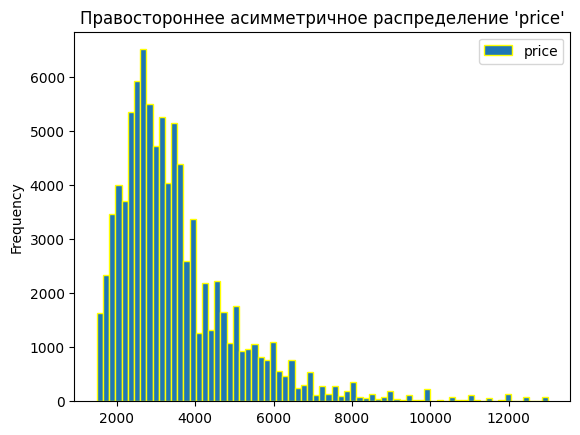

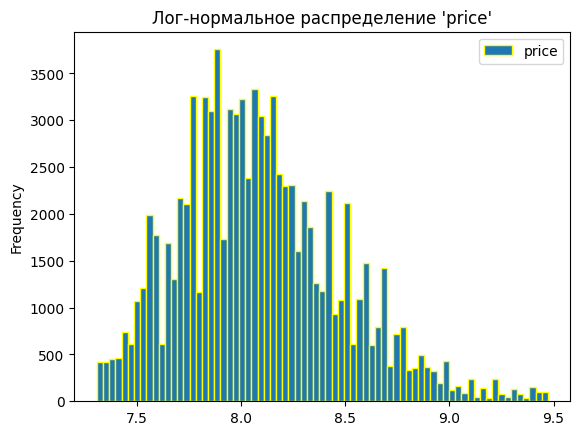

In [40]:
# 11.a

train_df[target].plot.hist(bins=73, edgecolor="yellow")
plt.title("Правостороннее асимметричное распределение 'price'")

np.log(train_df["price"]).to_frame().plot.hist(bins=73, edgecolor="yellow")
plt.title("Лог-нормальное распределение 'price'")

In [41]:
# 11.a

train_df["price_log"] = np.log(train_df["price"])

b. The next trick is outliers. The angle of the linear regression line depends strongly on outliers. And often you should remove these points from !allert! only training data. You should explain why they were removed from the training sample only. We recommend that you do this exercise and compare the results.  

>\# 11.b  

 Выбросы удаляются только из обучающих данных для:
  1. `Сохранения реалистичности тестовых данных`: тестовые данные, как правило, не имеют нормального распределения и на их основе мы можем наиболее точно оценить модель  
  
  2. `Предотвращение утечки данных`: если выбросы удалить до разделения данных на тестовую и обучающую выборки, то это приведет к неполноте данных, и, как следствие, к тому, что модель будет хуже предсказывать на реальных значениях  
  
  3. `Сохранения реальной обучающей способности модели`: если удалить выбросы из теста, то метрики оценки будут завышены


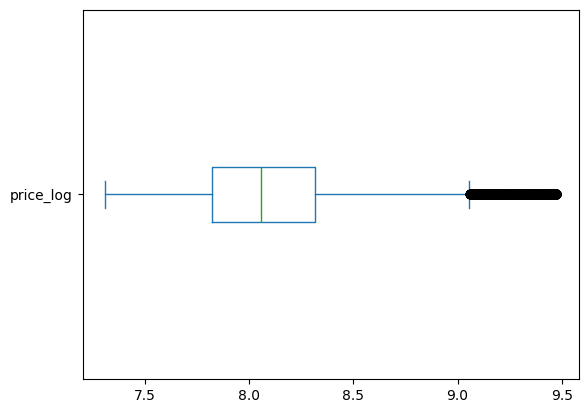

In [42]:
# 11.b

train_df["price_log"].plot.box(vert=False);

In [43]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    
    return (q25 - 1.5 * iqr, q75 + 1.5 * iqr)


boundaries = calculate_outliers(train_df["price_log"])

is_outlier = (train_df["price_log"] < boundaries[0]) | (train_df["price_log"] > boundaries[1])

In [44]:
train_df[is_outlier]["price_log"].describe()

count    1499.000000
mean        9.250363
std         0.123049
min         9.058936
25%         9.146868
50%         9.210340
75%         9.354441
max         9.472705
Name: price_log, dtype: float64

In [45]:
train_df.loc[is_outlier, "price_log"] = np.full(
    len(train_df.loc[is_outlier, "price_log"]), 
    train_df.loc[~is_outlier, "price_log"].max()
)

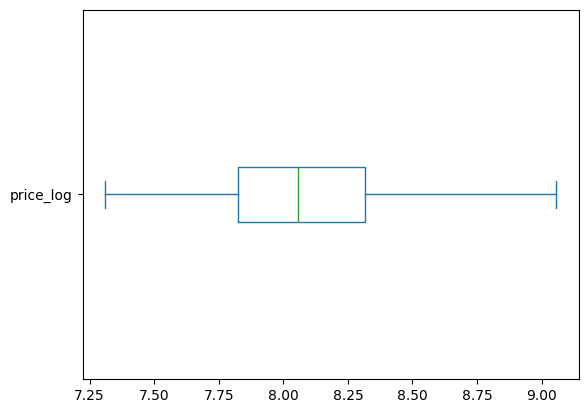

In [46]:
train_df["price_log"].plot.box(vert=False);

c. It will also be a useful exercise to implement a linear regression algorithm with batch and mini-batch training or analytical solution (as mentioned in 4.1).  

In [47]:
# 11.c

model = MyLinearRegression("analytical")
model.fit(train_df[most_common], train_df["price"])
train_predict = model.predict(train_df[most_common])
test_predict = model.predict(test_df[most_common])

display(
    "Test MAE", mean_absolute_error(test_df["price"], test_predict),
    "Test RMSE", root_mean_squared_error(test_df["price"], test_predict),
    "Test R2", r2_score(test_df["price"], test_predict),
)

'Test MAE'

736.0358888064825

'Test RMSE'

1070.3850677655678

'Test R2'

0.5460678598954488

### __Submission__
Save your code in Python JupyterNotebook. Your peer will load it and compare it with the basic solution. Your code should include answers to all mandatory questions. The additional task is up to you.